In [1]:
%matplotlib inline

import os
# assumes jupyter server launched from root dir of repo
filepath = os.path.abspath(os.path.join(os.getcwd(), '..'))
%cd $filepath

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append(os.path.abspath(filepath))

from notebooks.preprocess_util import *

/Users/cyz/survey/active_survey_lite


/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Suppress verbose warnings about missing fonts
import warnings
warnings.simplefilter('ignore')

In [3]:
response_filename = "data/cces/cces16_full.csv"
responses = pd.read_csv(response_filename, index_col=0)

In [4]:
responses.shape

(64600, 62)

In [5]:
# drop rows with no respones
responses = responses.dropna(how='all', axis=0)
responses.shape

(64600, 62)

In [6]:
# Drop questions with no responses
responses = responses.dropna(how='all', axis=1)
responses.shape

(64600, 62)

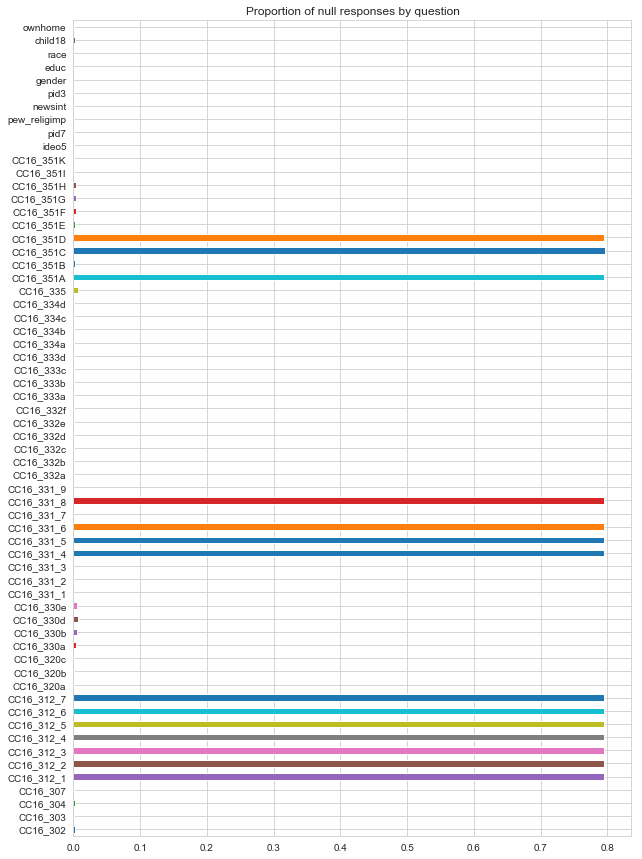

In [7]:
plot_na_proportion(responses)

In [8]:
# Drop questions with >75% nonresponse
na_proportion = compute_na_proportion(responses)
keep_questions = na_proportion < 0.75
responses = responses.iloc[:, keep_questions.tolist()]
responses.shape

(64600, 48)

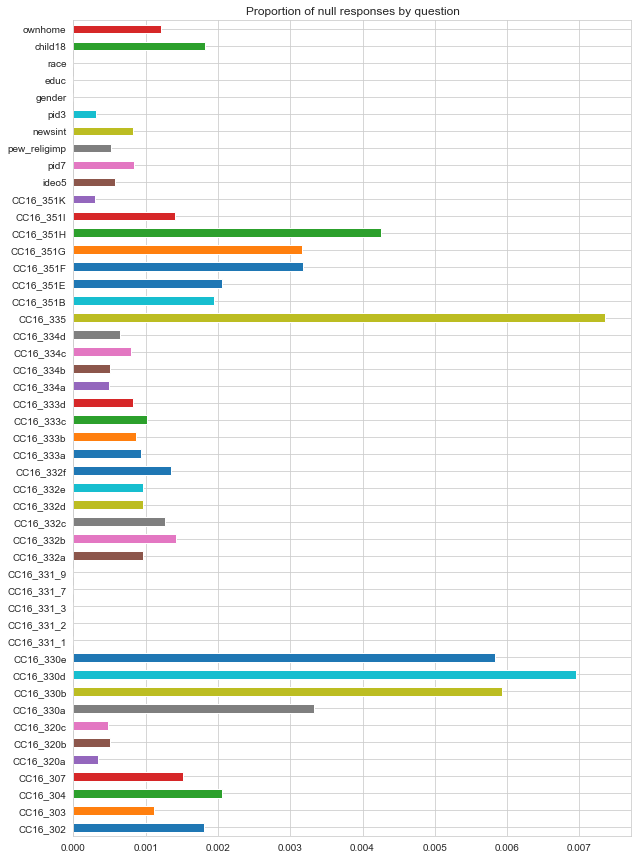

In [9]:
plot_na_proportion(responses)

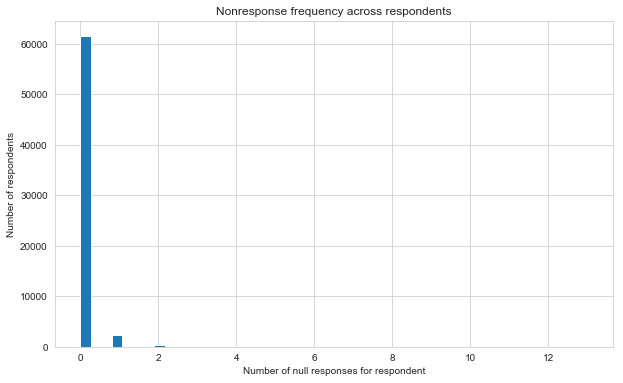

In [10]:
plot_nonresponse_freq(responses)

In [11]:
# display unique values and counts for all categorical variables
from IPython.display import display
cat_columns = responses.columns[responses.dtypes == 'object']
for column in cat_columns:
    display(responses[column].value_counts())

Democrat       24881
Independent    18238
Republican     15300
Not sure        3782
Other           2379
Name: pid3, dtype: int64

Female    35069
Male      29531
Name: gender, dtype: int64

High school graduate    16381
Some college            15685
4-year                  14884
Post-grad                8510
2-year                   7169
No HS                    1971
Name: educ, dtype: int64

White              46289
Black               7926
Hispanic            5238
Asian               2278
Mixed               1452
Other                760
Native American      522
Middle Eastern       135
Name: race, dtype: int64

No     46722
Yes    17760
Name: child18, dtype: int64

Own      40682
Rent     20859
Other     2981
Name: ownhome, dtype: int64

In [12]:
# NA out uncommon values
replace_values(responses, dict(
    pid3=['Not sure', 'Other'],
    educ=['No HS'],
    race=['Other', 'Native American', 'Middle Eastern'],
    ownhome=['Other']
))

Replacing 6161/64600 (9.54) values of pid3 with NA
Replacing 1971/64600 (3.05) values of educ with NA
Replacing 1417/64600 (2.19) values of race with NA
Replacing 2981/64600 (4.61) values of ownhome with NA


In [13]:
# create dummies for categorical variables
# drop_first=False to stay more true to survey setting, 
# also since we don't need full-rank design matrix
responses = pd.get_dummies(responses, columns=cat_columns, drop_first=False)

# remove spaces from column names
responses.columns = [col.replace(' ', '_') for col in responses]
responses.columns

Index(['CC16_302', 'CC16_303', 'CC16_304', 'CC16_307', 'CC16_320a',
       'CC16_320b', 'CC16_320c', 'CC16_330a', 'CC16_330b', 'CC16_330d',
       'CC16_330e', 'CC16_331_1', 'CC16_331_2', 'CC16_331_3', 'CC16_331_7',
       'CC16_331_9', 'CC16_332a', 'CC16_332b', 'CC16_332c', 'CC16_332d',
       'CC16_332e', 'CC16_332f', 'CC16_333a', 'CC16_333b', 'CC16_333c',
       'CC16_333d', 'CC16_334a', 'CC16_334b', 'CC16_334c', 'CC16_334d',
       'CC16_335', 'CC16_351B', 'CC16_351E', 'CC16_351F', 'CC16_351G',
       'CC16_351H', 'CC16_351I', 'CC16_351K', 'ideo5', 'pid7', 'pew_religimp',
       'newsint', 'pid3_Democrat', 'pid3_Independent', 'pid3_Republican',
       'gender_Female', 'gender_Male', 'educ_2-year', 'educ_4-year',
       'educ_High_school_graduate', 'educ_Post-grad', 'educ_Some_college',
       'race_Asian', 'race_Black', 'race_Hispanic', 'race_Mixed', 'race_White',
       'child18_No', 'child18_Yes', 'ownhome_Own', 'ownhome_Rent'],
      dtype='object')

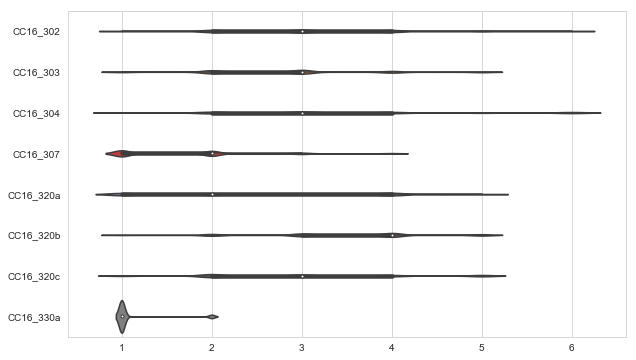

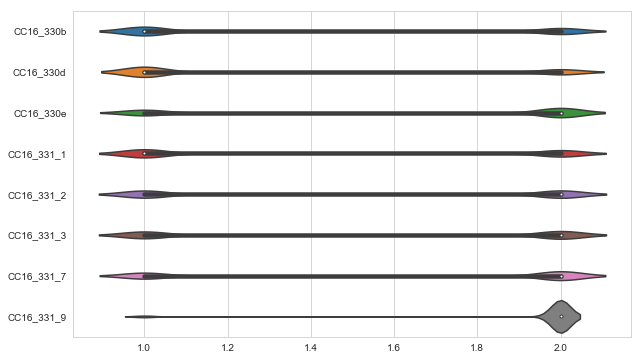

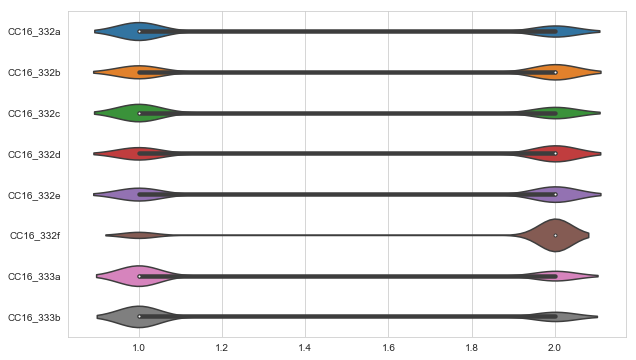

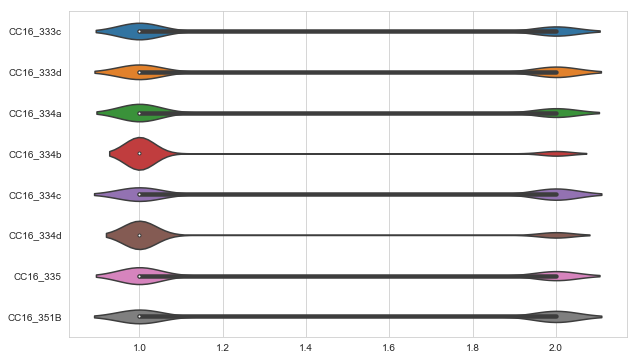

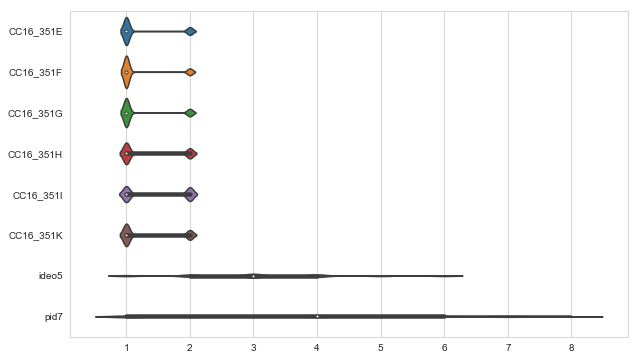

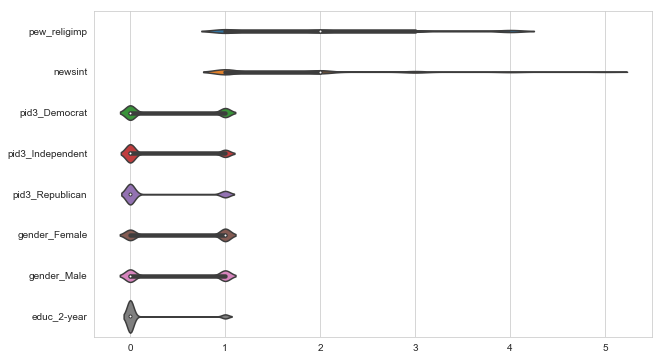

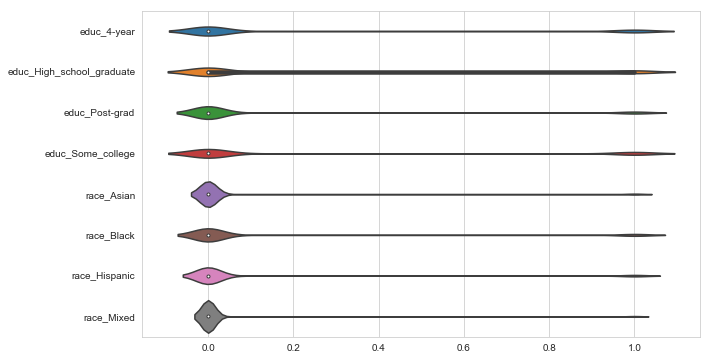

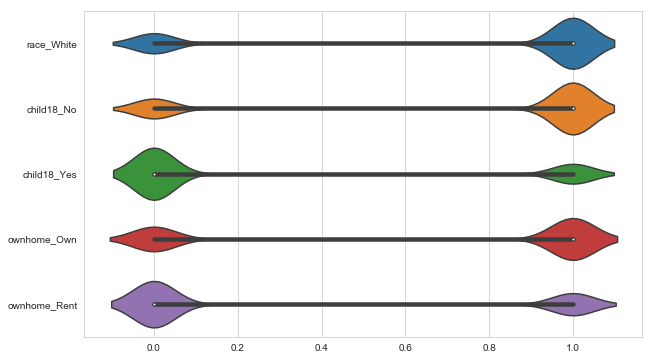

In [14]:
response_violin_plots(responses)

In [15]:
# Remove "Not sure", "Other" responses that break order; replace by NA
replace_values(responses, dict(
    CC16_302=[6],
    CC16_304=[6],
    CC16_320a=[5],
    CC16_320b=[5],
    CC16_320c=[5],
    ideo5=[6],
    pid7=[8],
    newsint=[5]
))

Replacing 2018/64600 (3.12) values of CC16_302 with NA
Replacing 10104/64600 (15.64) values of CC16_304 with NA
Replacing 2940/64600 (4.55) values of CC16_320a with NA
Replacing 8832/64600 (13.67) values of CC16_320b with NA
Replacing 10044/64600 (15.55) values of CC16_320c with NA
Replacing 4748/64600 (7.35) values of ideo5 with NA
Replacing 2067/64600 (3.20) values of pid7 with NA
Replacing 1791/64600 (2.77) values of newsint with NA


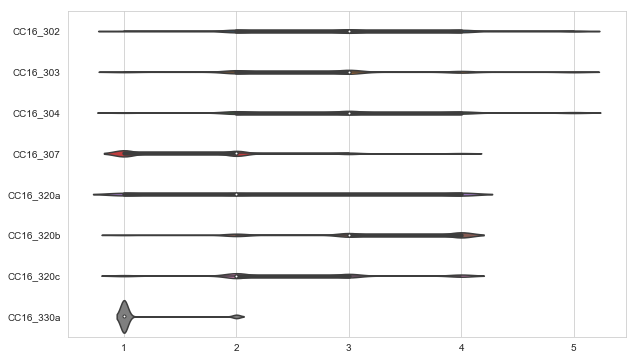

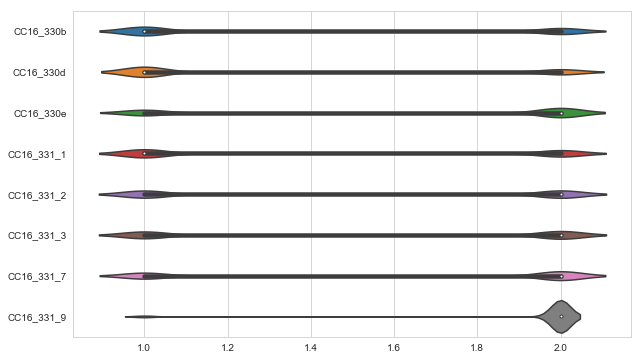

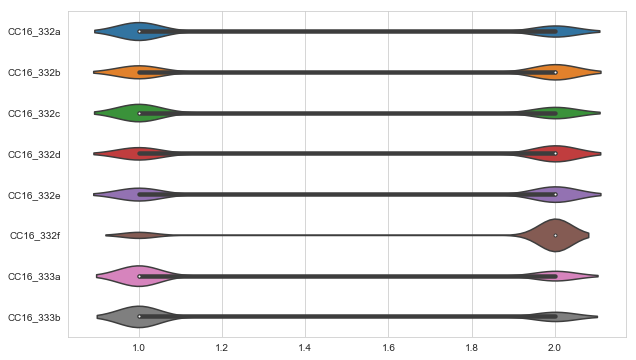

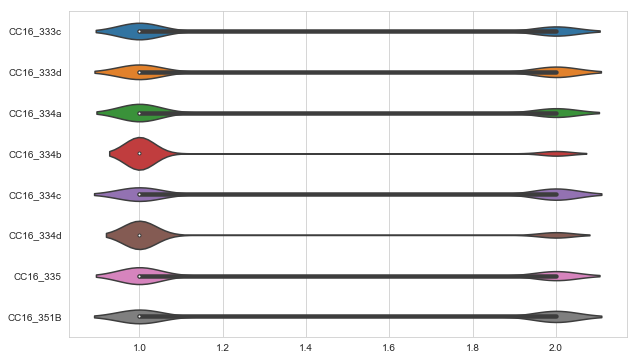

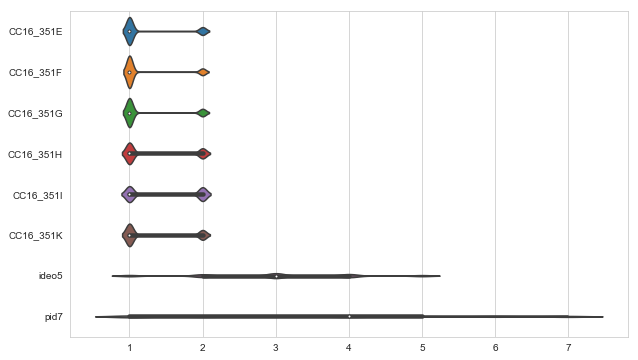

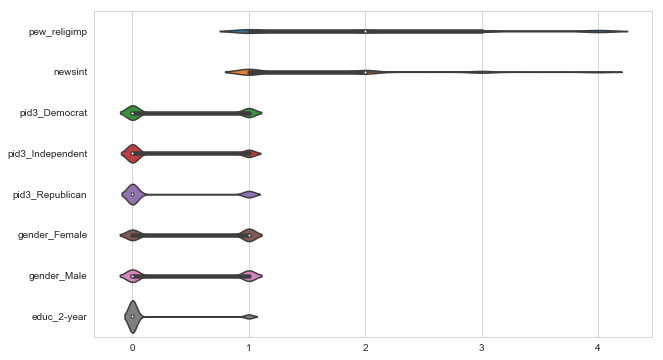

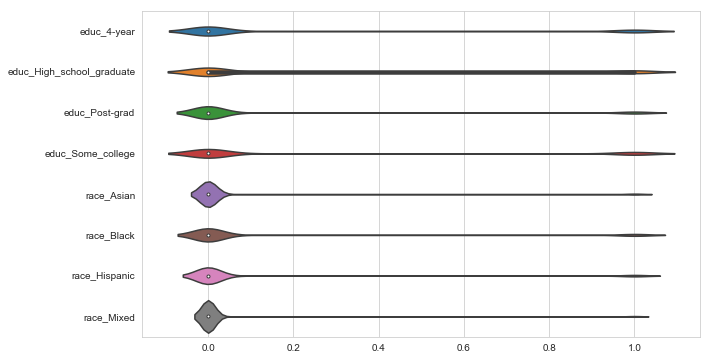

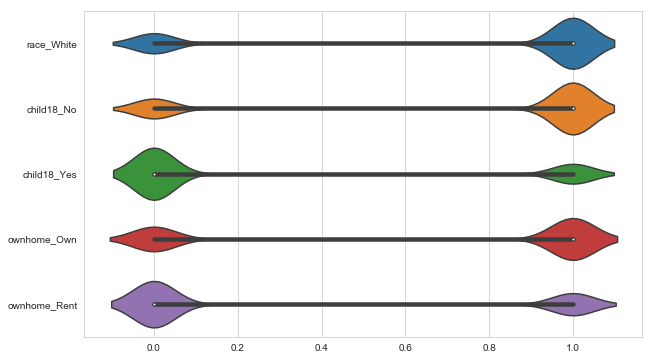

In [16]:
response_violin_plots(responses)

In [17]:
# center and scale responses
responses_scaled = center_and_scale(responses)

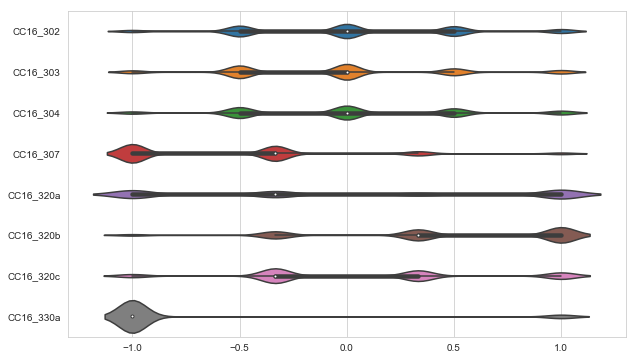

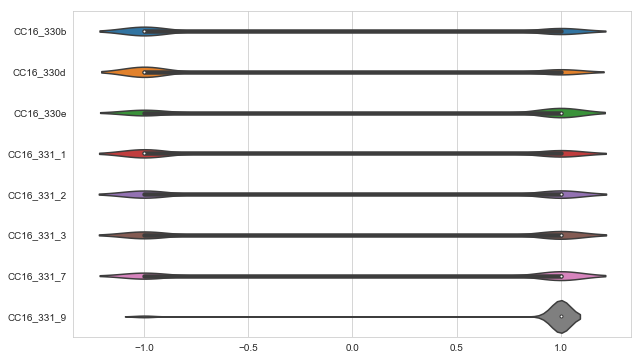

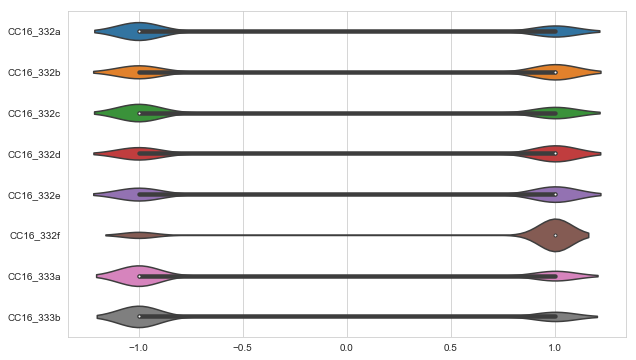

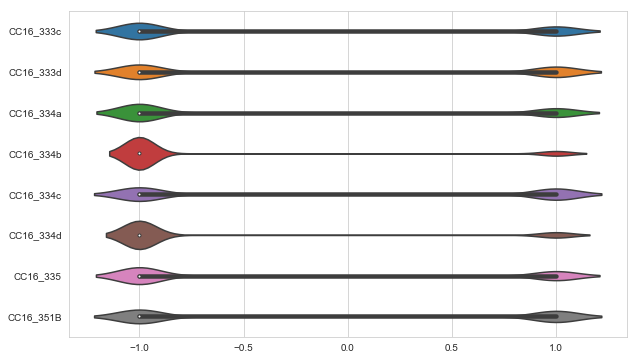

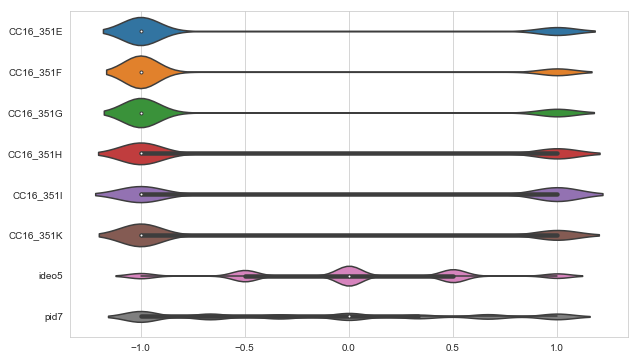

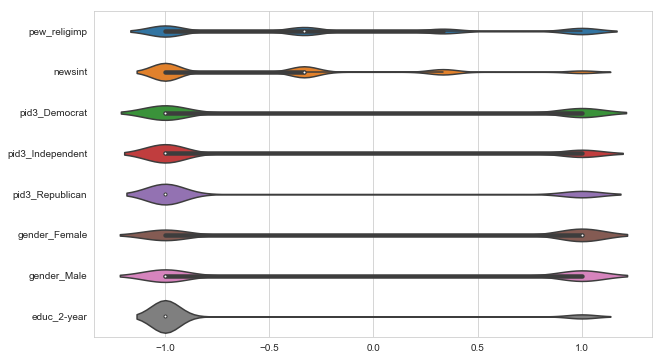

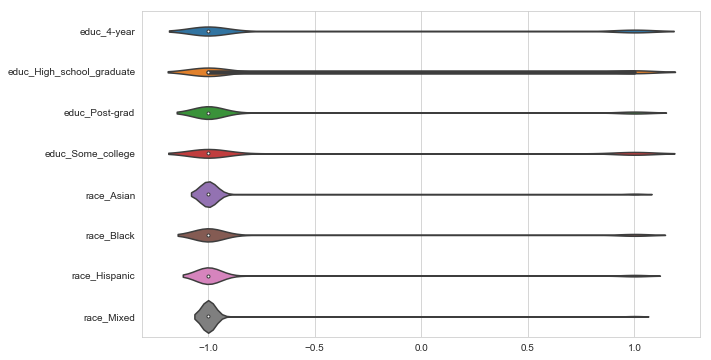

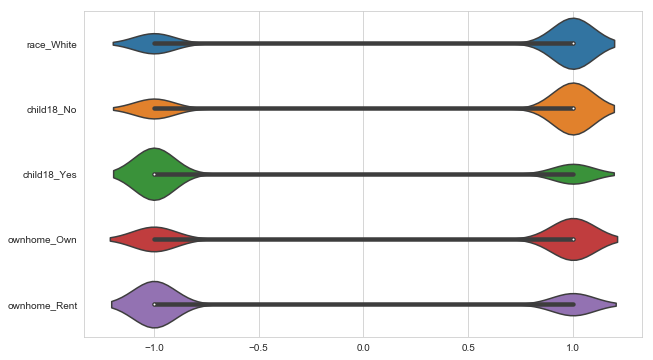

In [18]:
response_violin_plots(responses_scaled)

In [19]:
# Save full set of questions and covariates
responses_scaled.to_csv("data/cces/cces16_full_cs.csv")

def cols_with_prefix(df, prefix):
    return [col for col in df if col.startswith(prefix)]

# Save only responses to survey questions
base_cols = cols_with_prefix(responses_scaled, 'CC16_')
responses_scaled[base_cols].to_csv("data/cces/cces16_base_cs.csv")

# Save reduced sets of questions and covariates
cols_with_pol_ids = base_cols + cols_with_prefix(responses_scaled, 'pid3') + ['ideo5', 'pid7']
responses_scaled[cols_with_pol_ids].to_csv("data/cces/cces16_with_pol_ids_cs.csv")

cols_with_demos = cols_with_pol_ids + cols_with_prefix(responses_scaled, 'gender') + \
    cols_with_prefix(responses_scaled, 'race')
responses_scaled[cols_with_demos].to_csv("data/cces/cces16_with_demos_cs.csv")


In [20]:
# get list of covariate columns
','.join([col for col in responses_scaled if not col.startswith('CC16_')])

'ideo5,pid7,pew_religimp,newsint,pid3_Democrat,pid3_Independent,pid3_Republican,gender_Female,gender_Male,educ_2-year,educ_4-year,educ_High_school_graduate,educ_Post-grad,educ_Some_college,race_Asian,race_Black,race_Hispanic,race_Mixed,race_White,child18_No,child18_Yes,ownhome_Own,ownhome_Rent'